# FAIKR Module 3 Project

# Mohammad Amin Nazerzadeh  0001032832

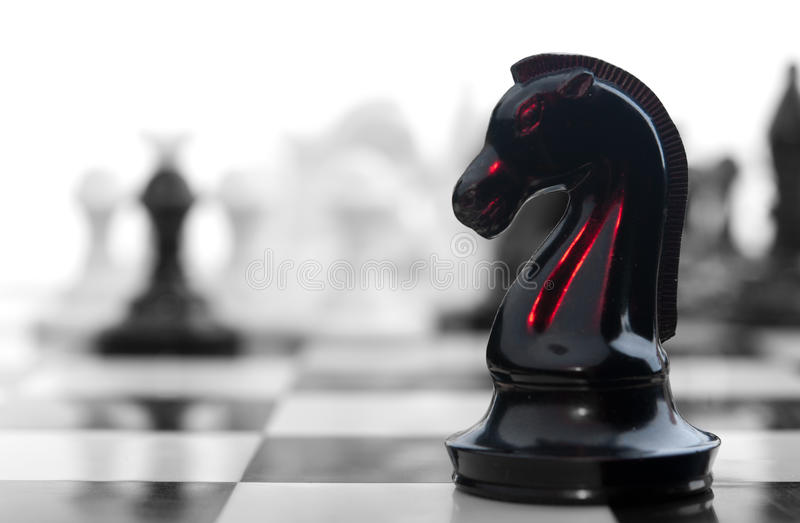

In [5]:
%matplotlib inline
from IPython.display import Image
Image("horse.jpg")

In [6]:
import warnings
warnings.filterwarnings('ignore')

The task of this project is predicting whether or not a sick horse survived, noted by the "outcome" variable in the data, based upon past medical conditions. I chose this dataset because there are alot of NAs (not a numbers) in the data. And dealing with them is the main struggle here. Also because of the proportion of NA's, imputation would not work porperly in this case. However, Bayesian networks have the ability to take into account the whole data due to their probabilistic nature and I've exploited this ability in this project.

In [3]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator

In [4]:
data = pd.read_csv("horse.csv", usecols=[ 'age', 'surgery', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time'
                  , 'pain', 'abdominal_distention','peristalsis', 'temp_of_extremities', 'outcome'])

There are ten features in the dataset. In order:
* surgery: If the horse had a surgery record.
* age: If it is an adult or a young horse.
* temperature of extremities(temp_of_extermities): a subjective indication of peripheral circulation.
* peripheral pulse: normal or increased p.p. are indicative of adequate circulation while reduced or absent indicate poor perfusion.
* mucous membranes: a subjective measurement of colour.
* capillary refill time: a clinical judgement. The longer the refill, the poorer the circulation.
* pain: a subjective judgement of the horse's pain level.
* peristalsis: an indication of the activity in the horse's gut. As the gut becomes more distended or the horse becomes more toxic, the activity decreases.
* abdominal distention: an animal with abdominal distension is likely to be painful and have reduced gut motility. a horse with severe abdominal distension is likely to require surgery just tio relieve the pressure.
* outcome: what eventually happened to the horse? Lived, Died or was euthanized. 

In [5]:
data

,surgery,age,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,outcome
0,no,adult,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,died
1,yes,adult,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,euthanized
2,no,adult,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,lived
3,yes,young,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,died
4,no,adult,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,died
...,...,...,...,...,...,...,...,...,...,...
294,yes,adult,cold,NaN,pale_cyanotic,more_3_sec,depressed,absent,NaN,euthanized
295,no,adult,cool,increased,pale_cyanotic,more_3_sec,severe_pain,hypomotile,moderate,euthanized
296,yes,adult,cold,reduced,pale_cyanotic,less_3_sec,severe_pain,absent,moderate,died
297,yes,adult,cool,reduced,pale_pink,less_3_sec,mild_pain,hypomotile,moderate,lived


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   surgery                299 non-null    object
 1   age                    299 non-null    object
 2   temp_of_extremities    243 non-null    object
 3   peripheral_pulse       230 non-null    object
 4   mucous_membrane        252 non-null    object
 5   capillary_refill_time  267 non-null    object
 6   pain                   244 non-null    object
 7   peristalsis            255 non-null    object
 8   abdominal_distention   243 non-null    object
 9   outcome                299 non-null    object
dtypes: object(10)
memory usage: 23.5+ KB


Plotting the relations between missing values of different features to check for the possibility of imputing the missing values. 

[]

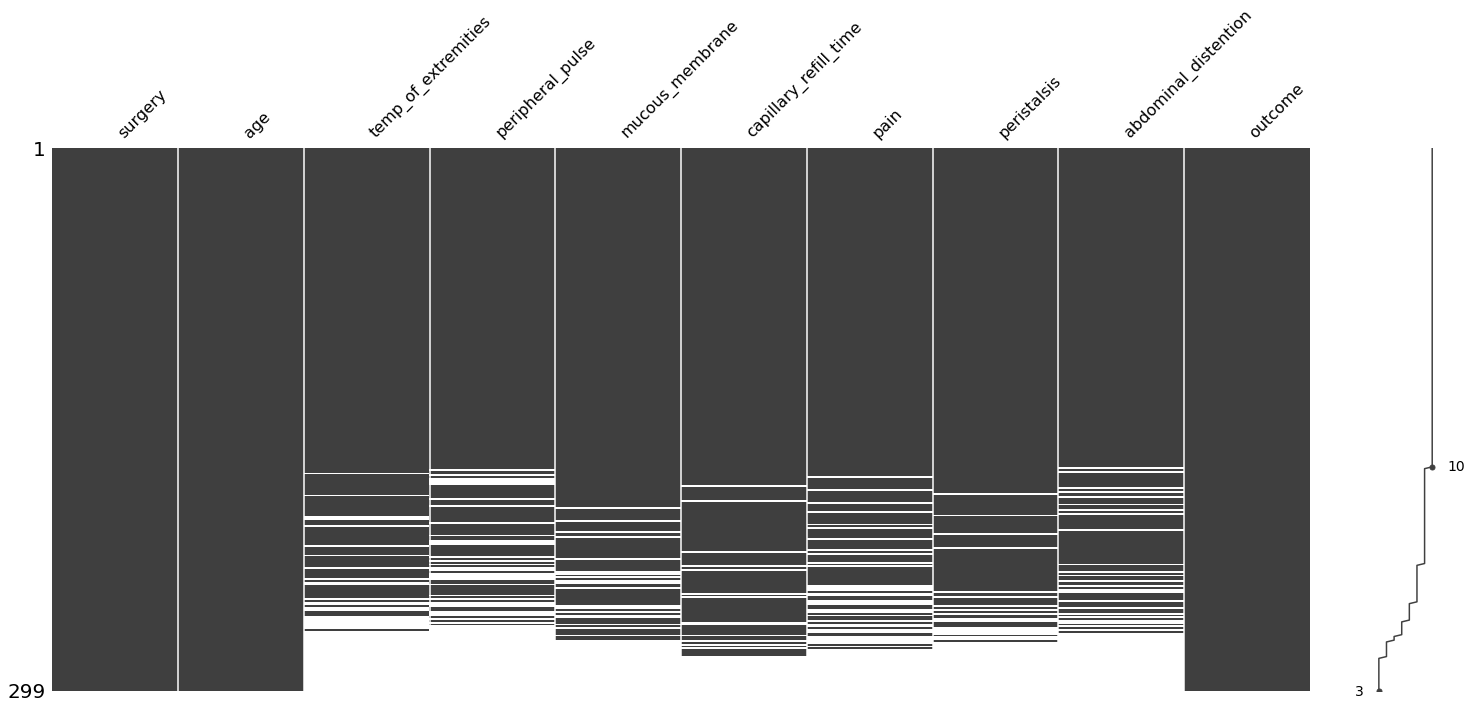

In [7]:
msno.matrix(msno.nullity_sort(data, sort='descending'))
plt.plot()

In the above plot you can see a large proportion of the data having missing values. Also a noticable proportion of data have seven missing features.

[]

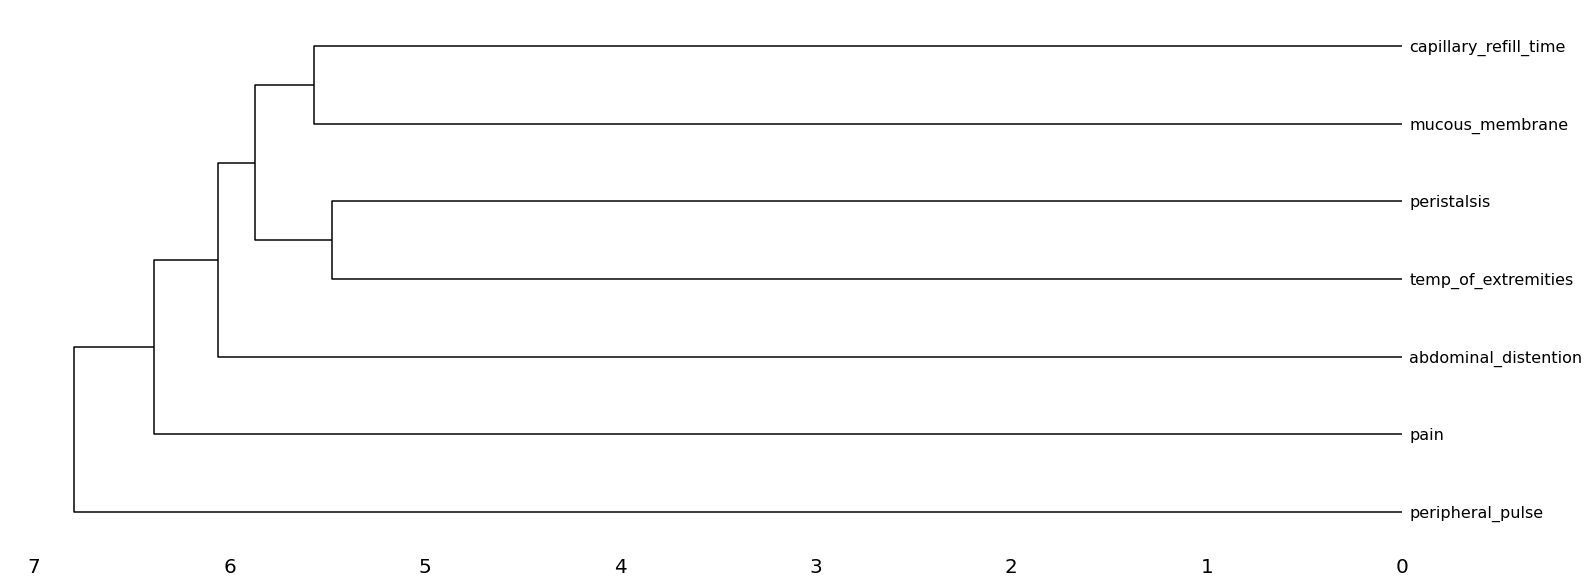

In [8]:
msno.dendrogram(data.drop(columns=['outcome', 'surgery','age']), orientation='left')
plt.plot()

The dendrogram plot visualizes the degree of null predictability of cluster of features by other clusters. As you can see the splits of the dendrogram are happen near the root so the features can not predict well the occurence of null values in other features. 

In [9]:
data.nunique()

surgery                  2
age                      2
temp_of_extremities      4
peripheral_pulse         4
mucous_membrane          6
capillary_refill_time    3
pain                     5
peristalsis              4
abdominal_distention     4
outcome                  3
dtype: int64

# Model:

A proposed model after discussing the likely causal relations in the features with a veterinary student.

In [101]:
relations = ([(x, 'outcome') for x in data.columns.values] + [
    ('abdominal_distention', 'temp_of_extremities'), 
    ('abdominal_distention', 'peristalsis'),
                        ('peripheral_pulse', 'capillary_refill_time'), ('peripheral_pulse', 'mucous_membrane'), 
                        ('abdominal_distention', 'pain'), ('temp_of_extremities', 'pain')
])
relations.remove(('outcome', 'outcome'))
model = BayesianNetwork(relations)

In [102]:
relations

[('surgery', 'outcome'),
 ('age', 'outcome'),
 ('temp_of_extremities', 'outcome'),
 ('peripheral_pulse', 'outcome'),
 ('mucous_membrane', 'outcome'),
 ('capillary_refill_time', 'outcome'),
 ('pain', 'outcome'),
 ('peristalsis', 'outcome'),
 ('abdominal_distention', 'outcome'),
 ('abdominal_distention', 'temp_of_extremities'),
 ('abdominal_distention', 'peristalsis'),
 ('peripheral_pulse', 'capillary_refill_time'),
 ('peripheral_pulse', 'mucous_membrane'),
 ('abdominal_distention', 'pain'),
 ('temp_of_extremities', 'pain')]

In [103]:
model.get_children('peripheral_pulse')

['outcome', 'capillary_refill_time', 'mucous_membrane']

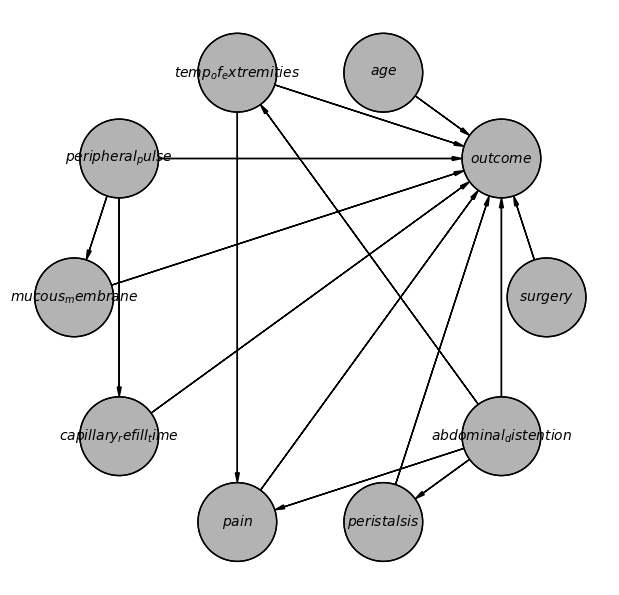

In [104]:
import daft
from daft import PGM, _rendering_context
pgm = model.to_daft(pgm_params={'dpi':100, 'grid_unit':6, 'node_unit':2})
pgm.render()

Ancesteral Graph of Pain (It is interesting because it consists of a 'Causal Trail', 'Common Effect' ,and 'Common Cause'):

In [105]:
ag = model.get_ancestral_graph('pain')

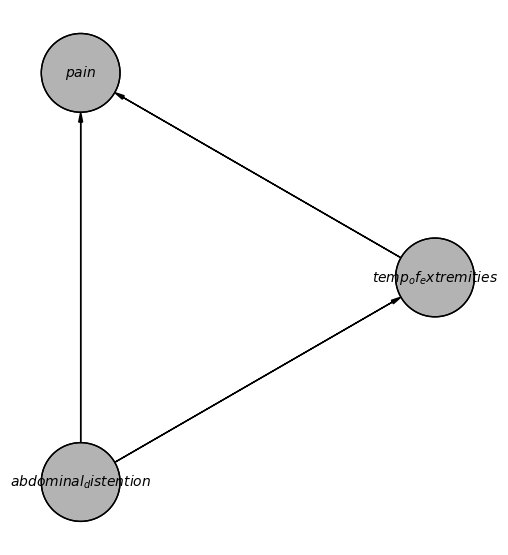

In [106]:
pgm = ag.to_daft(pgm_params={'dpi':100, 'grid_unit':6, 'node_unit':2})
pgm.render()

Active trails to pain

In [107]:
model.active_trail_nodes('pain')

{'pain': {'abdominal_distention',
  'outcome',
  'pain',
  'peristalsis',
  'temp_of_extremities'}}

Markov blanket of variable pain. It consists of all other variables because all of them are either it's parent or child or parent of it's children. 

In [108]:
model.get_markov_blanket('pain')

['capillary_refill_time',
 'peristalsis',
 'temp_of_extremities',
 'age',
 'mucous_membrane',
 'abdominal_distention',
 'outcome',
 'peripheral_pulse',
 'surgery']

Network independencies:

In [109]:
model.get_independencies()

(capillary_refill_time ⟂ age, temp_of_extremities, abdominal_distention, peristalsis, pain, surgery)
(capillary_refill_time ⟂ age, temp_of_extremities, abdominal_distention, pain, surgery | peristalsis)
(capillary_refill_time ⟂ temp_of_extremities, abdominal_distention, peristalsis, pain, surgery | age)
(capillary_refill_time ⟂ age, abdominal_distention, peristalsis, pain, surgery | temp_of_extremities)
(capillary_refill_time ⟂ age, temp_of_extremities, abdominal_distention, peristalsis, pain, surgery | mucous_membrane)
(capillary_refill_time ⟂ age, temp_of_extremities, peristalsis, pain, surgery | abdominal_distention)
(capillary_refill_time ⟂ age, temp_of_extremities, mucous_membrane, abdominal_distention, peristalsis, pain, surgery | peripheral_pulse)
(capillary_refill_time ⟂ age, temp_of_extremities, abdominal_distention, peristalsis, surgery | pain)
(capillary_refill_time ⟂ age, temp_of_extremities, abdominal_distention, peristalsis, pain | surgery)
(capillary_refill_time ⟂ temp_o

## State Counts

In [110]:
from pgmpy.estimators import ParameterEstimator
pe = ParameterEstimator(model, data)

ِYou see here that state counts of a chosen feature (pain in here) is sparse. It means that there are combinations of parents whose count is zero. This alarms us about the problem of overfitting. We will later see that in this case a bayesian learning is a better choice than maximum likelihood learning.

In [111]:
pe.state_counts('pain')

abdominal_distention moderate                  none                  severe  \
temp_of_extremities      cold cool normal warm cold cool normal warm   cold   
pain                                                                          
alert                     0.0  1.0    0.0  0.0  0.0  2.0   12.0  5.0    0.0   
depressed                 2.0  9.0    1.0  0.0  2.0  4.0    7.0  1.0    3.0   
extreme_pain              0.0  9.0    1.0  0.0  0.0  2.0    1.0  0.0    3.0   
mild_pain                 3.0  5.0    4.0  3.0  0.0  6.0    8.0  2.0    0.0   
severe_pain               2.0  3.0    3.0  2.0  0.0  0.0    3.0  1.0    1.0   

abdominal_distention                  slight                   
temp_of_extremities  cool normal warm   cold cool normal warm  
pain                                                           
alert                 0.0    1.0  0.0    0.0  2.0    3.0  3.0  
depressed             2.0    1.0  0.0    0.0  6.0    4.0  1.0  
extreme_pain          6.0    1.0  0.0    0.0  2.0    1.0  0.0  
mild_pain             0.0    2.0  0.0    1.0  8.0    8.0  2.0  
severe_pain           6.0    0.0  0.0    1.0  4.0    0.0  0.0

# Parameter Learning:

## Maximum Likelihood Estimation

Fitting a Maximumlikelihood estimator without considering the Nans.

In [112]:
mle = MaximumLikelihoodEstimator(model, data)

In [113]:
print(mle.estimate_cpd('abdominal_distention'))

+--------------------------------+----------+
| abdominal_distention(moderate) | 0.272727 |
+--------------------------------+----------+
| abdominal_distention(none)     | 0.318182 |
+--------------------------------+----------+
| abdominal_distention(severe)   | 0.147727 |
+--------------------------------+----------+
| abdominal_distention(slight)   | 0.261364 |
+--------------------------------+----------+


Fitting a Maximumlikelihood estimator considering the Nans.

In [114]:
model.fit(data, estimator=MaximumLikelihoodEstimator, complete_samples_only=False)

In [115]:
print(model.get_cpds('abdominal_distention'))

+--------------------------------+----------+
| abdominal_distention(moderate) | 0.26749  |
+--------------------------------+----------+
| abdominal_distention(none)     | 0.308642 |
+--------------------------------+----------+
| abdominal_distention(severe)   | 0.156379 |
+--------------------------------+----------+
| abdominal_distention(slight)   | 0.26749  |
+--------------------------------+----------+


In [116]:
model.check_model()

True

Bayesian information criterion (BIC) is a score for the fitness of the function which while trying to maximize the likelihood of the model fitting the data, regulates for the complexity of the model. In this way it tries to account for the overfitting that may happen.

In [117]:
from pgmpy.estimators import BicScore, BDeuScore
bdeu = BDeuScore(data, equivalent_sample_size=10)
bic = BicScore(data)
print("BIC score: ",bic.score(model))
print("BDeu score: ", bdeu.score(model))

BIC score:  -527212.6906943126
BDeu score:  -1903.4356351810604


Here we try the inference on the model by adding different evidences and observe the changes in the posterior probability distributions.

In [118]:
infer = VariableElimination(model)

In [119]:
print(infer.query(['outcome'], show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.3244 |
+---------------------+----------------+
| outcome(euthanized) |         0.3162 |
+---------------------+----------------+
| outcome(lived)      |         0.3593 |
+---------------------+----------------+


In [120]:
data['pain'].unique()

array(['extreme_pain', 'mild_pain', 'depressed', nan, 'severe_pain',
       'alert'], dtype=object)

In [121]:
print(infer.query(['outcome'], evidence={'pain':'extreme_pain'}, show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.3561 |
+---------------------+----------------+
| outcome(euthanized) |         0.3187 |
+---------------------+----------------+
| outcome(lived)      |         0.3252 |
+---------------------+----------------+


In [122]:
data['peripheral_pulse'].unique()

array(['reduced', nan, 'normal', 'absent', 'increased'], dtype=object)

In [123]:
print(infer.query(['outcome'], evidence={'peripheral_pulse': 'absent'}, show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.3329 |
+---------------------+----------------+
| outcome(euthanized) |         0.3350 |
+---------------------+----------------+
| outcome(lived)      |         0.3321 |
+---------------------+----------------+


In [124]:
print(infer.query(['outcome'], evidence={'peripheral_pulse': 'absent', 'pain': 'extreme_pain'}, show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.3333 |
+---------------------+----------------+
| outcome(euthanized) |         0.3333 |
+---------------------+----------------+
| outcome(lived)      |         0.3333 |
+---------------------+----------------+


In [125]:
data['abdominal_distention'].unique()

array(['severe', 'slight', 'none', nan, 'moderate'], dtype=object)

In [126]:
print(infer.query(['outcome'], evidence={'peripheral_pulse': 'absent', 'pain': 'extreme_pain'
                                         , 'abdominal_distention': 'severe'}, show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.3333 |
+---------------------+----------------+
| outcome(euthanized) |         0.3333 |
+---------------------+----------------+
| outcome(lived)      |         0.3333 |
+---------------------+----------------+


As you can see the network seems not to have learned much from the data and tries to guess the queried value randomly even when providing more evidence. In the following sections I try to incorporate other ways to build a better model.

# Structure Learning:

Cost of exhaustive search is too much. It is sutiable for networks containing at most 5 nodes. So we use different heuristics to estimate a network explaining the data. Hill climbing is a local search method and at each step tries to find the best neighborhood of the current model till it reaches a local maxima. The neighbours are considered only to be a result of adding or removing an edge from the network.

## HillClimbing

In [35]:
from pgmpy.estimators import BDeuScore
from pgmpy.estimators import BicScore
from pgmpy.estimators import HillClimbSearch

hc = HillClimbSearch(data=data, complete_samples_only=False)
best_model = hc.estimate()

In [36]:
print(best_model.edges())

[('age', 'mucous_membrane'), ('age', 'abdominal_distention'), ('age', 'temp_of_extremities'), ('age', 'pain'), ('peripheral_pulse', 'temp_of_extremities'), ('peripheral_pulse', 'abdominal_distention'), ('peripheral_pulse', 'outcome'), ('peripheral_pulse', 'peristalsis'), ('mucous_membrane', 'pain'), ('capillary_refill_time', 'peripheral_pulse'), ('capillary_refill_time', 'mucous_membrane'), ('capillary_refill_time', 'abdominal_distention'), ('pain', 'surgery'), ('peristalsis', 'mucous_membrane'), ('peristalsis', 'abdominal_distention'), ('peristalsis', 'surgery'), ('outcome', 'pain'), ('outcome', 'surgery')]


In [37]:
best_model = BayesianNetwork(best_model)

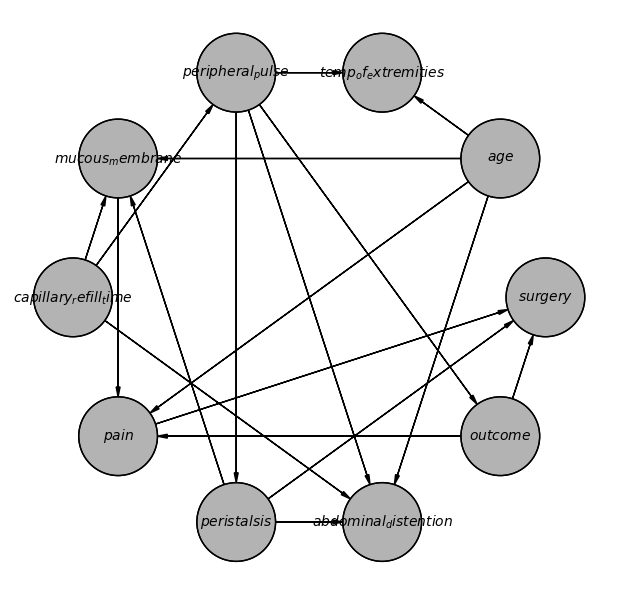

In [38]:
pgm = best_model.to_daft(pgm_params={'dpi':100, 'grid_unit':6, 'node_unit':2})
pgm.render()

In [39]:
best_model.fit(data, complete_samples_only=False, estimator = MaximumLikelihoodEstimator)

Commonly used scores to measure the fit between model and data are Bayesian Dirichlet scores such as BDeu or K2 and the Bayesian Information Criterion (BIC). Here we used BDeu and BIC to compare fitness of the models. 
With reference to $\href{https://link.springer.com/article/10.1007/s41237-018-0048-x}{this paper}$, if we suppose $r_i$ be the number of states of each variable, $\Pi_{X_i} $ be the parents of the given variable, and $q_i$ be the number of possible configurations of parent of the given variable, then we have: 
$$ BIC = \sum_{i=1}^{N}BIC(X_i | \Pi_{X_i}) = \sum_{i=1}^{N}[ log p(X_i | \Pi_{X_i}) - \frac{log n}{2}q_i(r_i - 1)]  $$


In [40]:
bdeu = BDeuScore(data, equivalent_sample_size=10)
bic = BicScore(data)
print("BIC score: ",bic.score(best_model))
print("BDeu score: ", bdeu.score(best_model))

BIC score:  -3299.311273497099
BDeu score:  -1852.6887813670212


As you can see the BIC score has a signifcant difference from the previous network. 

In [41]:
infer = VariableElimination(best_model)

In [42]:
print(infer.query(['outcome'], show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.2556 |
+---------------------+----------------+
| outcome(euthanized) |         0.1379 |
+---------------------+----------------+
| outcome(lived)      |         0.6065 |
+---------------------+----------------+


In [43]:
print(infer.query(['outcome'], evidence={'pain':'extreme_pain'}, show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.5327 |
+---------------------+----------------+
| outcome(euthanized) |         0.0801 |
+---------------------+----------------+
| outcome(lived)      |         0.3872 |
+---------------------+----------------+


In [44]:
print(infer.query(['outcome'], evidence={'peripheral_pulse': 'absent'}, show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.3750 |
+---------------------+----------------+
| outcome(euthanized) |         0.5000 |
+---------------------+----------------+
| outcome(lived)      |         0.1250 |
+---------------------+----------------+


In [45]:
print(infer.query(['outcome'], evidence={'peripheral_pulse': 'absent', 'pain': 'extreme_pain'}, show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.6502 |
+---------------------+----------------+
| outcome(euthanized) |         0.2554 |
+---------------------+----------------+
| outcome(lived)      |         0.0944 |
+---------------------+----------------+


In [46]:
print(infer.query(['outcome'], evidence={'peripheral_pulse': 'absent', 'pain': 'extreme_pain'
                                         , 'abdominal_distention': 'severe'}, show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.6456 |
+---------------------+----------------+
| outcome(euthanized) |         0.2649 |
+---------------------+----------------+
| outcome(lived)      |         0.0895 |
+---------------------+----------------+


In [47]:
from pgmpy.estimators import ParameterEstimator
pe = ParameterEstimator(best_model, data)

In [48]:
pe.state_counts('pain')

age                   adult                                               \
mucous_membrane bright_pink                  bright_red                    
outcome                died euthanized lived       died euthanized lived   
pain                                                                       
alert                   1.0        0.0   4.0        0.0        0.0   0.0   
depressed               0.0        0.0   9.0        5.0        1.0   0.0   
extreme_pain            0.0        0.0   0.0        0.0        0.0   1.0   
mild_pain               0.0        0.0   1.0        0.0        0.0   5.0   
severe_pain             1.0        1.0   0.0        4.0        2.0   0.0   

age                                                         ...         young  \
mucous_membrane dark_cyanotic                  normal_pink  ... dark_cyanotic   
outcome                  died euthanized lived        died  ...         lived   
pain                                                        ...                 
alert                     0.0        0.0   0.0         0.0  ...           0.0   
depressed                 0.0        2.0   1.0         2.0  ...           0.0   
extreme_pain              3.0        0.0   1.0         1.0  ...           0.0   
mild_pain                 0.0        0.0   1.0         2.0  ...           0.0   
severe_pain               1.0        0.0   0.0         0.0  ...           0.0   

age                                                                          \
mucous_membrane normal_pink                  pale_cyanotic                    
outcome                died euthanized lived          died euthanized lived   
pain                                                                          
alert                   0.0        0.0   0.0           0.0        0.0   0.0   
depressed               0.0        0.0   0.0           0.0        0.0   0.0   
extreme_pain            0.0        0.0   0.0           0.0        0.0   0.0   
mild_pain               0.0        0.0   1.0           0.0        0.0   0.0   
severe_pain             0.0        0.0   1.0           1.0        0.0   0.0   

age                                         
mucous_membrane pale_pink                   
outcome              died euthanized lived  
pain                                        
alert                 0.0        0.0   0.0  
depressed             0.0        0.0   0.0  
extreme_pain          1.0        0.0   0.0  
mild_pain             0.0        0.0   0.0  
severe_pain           0.0        0.0   0.0  

[5 rows x 36 columns]

ِYou see here that state counts of a chosen feature (pain in here) is sparse. It means that there are combinations of parents whose count is zero. This alarms us about the problem of overfitting. So, in this case bayesian learning is a better choice than maximum likelihood learning. In bayesian learning, we add priors to the model which are set based on the prior knowledge about the problem. 

One can think of the priors as consisting in pseudo state counts, that are added to the actual counts before normalization. Unless one wants to encode specific beliefs about the distributions of the variables, one commonly chooses uniform priors, i.e. ones that deem all states equiprobable.
A very simple prior is the so-called K2 prior, which simply adds 1 to the count of every single state. A somewhat more sensible choice of prior is BDeu (Bayesian Dirichlet equivalent uniform prior). For BDeu we need to specify an equivalent sample size N and then the pseudo-counts are the equivalent of having observed N uniform samples of each variable (and each parent configuration). In other words we have: 
$$ pseudoCounts = \frac{equivalentSampleSize}{nodeCardinality\times np.prod(parentsCardinalities)}$$

In [49]:
from pgmpy.estimators import BayesianEstimator
best_model.fit(data, estimator=BayesianEstimator, prior_type = "BDeu", equivalent_sample_size = 10, complete_samples_only=False)

In [50]:
infer = VariableElimination(best_model)

In [51]:
print(infer.query(['outcome'], show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.2587 |
+---------------------+----------------+
| outcome(euthanized) |         0.1460 |
+---------------------+----------------+
| outcome(lived)      |         0.5952 |
+---------------------+----------------+


In [52]:
print(infer.query(['outcome'], evidence={'pain':'extreme_pain'}, show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.5223 |
+---------------------+----------------+
| outcome(euthanized) |         0.0902 |
+---------------------+----------------+
| outcome(lived)      |         0.3876 |
+---------------------+----------------+


In [53]:
print(infer.query(['outcome'], evidence={'peripheral_pulse': 'absent'}, show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.3651 |
+---------------------+----------------+
| outcome(euthanized) |         0.4603 |
+---------------------+----------------+
| outcome(lived)      |         0.1746 |
+---------------------+----------------+


In [54]:
print(infer.query(['outcome'], evidence={'peripheral_pulse': 'absent', 'pain': 'extreme_pain'}, show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.6216 |
+---------------------+----------------+
| outcome(euthanized) |         0.2483 |
+---------------------+----------------+
| outcome(lived)      |         0.1301 |
+---------------------+----------------+


In [55]:
print(infer.query(['outcome'], evidence={'peripheral_pulse': 'absent', 'pain': 'extreme_pain'
                                         , 'abdominal_distention': 'severe'}, show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.6227 |
+---------------------+----------------+
| outcome(euthanized) |         0.2520 |
+---------------------+----------------+
| outcome(lived)      |         0.1253 |
+---------------------+----------------+


# Conditional Independence Test:

A different, but quite straightforward approach to build a DAG from data is identifying independencies in the data set using hypothesis tests (chi-squared tests) which are meaningful to extract causual relations in the dataset.
Then we construct DAG (pattern) according to identified independencies.

In [56]:
from pgmpy.estimators import PC
est = PC(data)
model = est.estimate(variant='orig', return_type='dag', significance_level=0.05, show_progress=False)

In [57]:
model = BayesianNetwork(model)

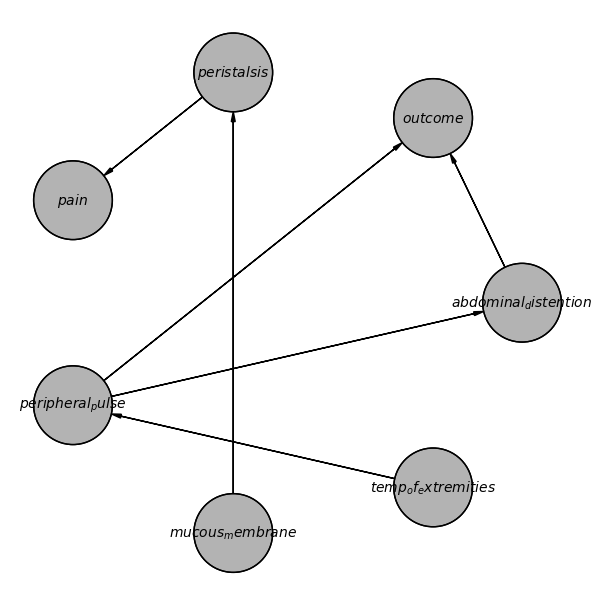

In [58]:
pgm = model.to_daft(pgm_params={'dpi':100, 'grid_unit':6, 'node_unit':2})
pgm.render()

In [59]:
bdeu = BDeuScore(data, equivalent_sample_size=10)
bic = BicScore(data)
print("BIC score: ",bic.score(model))
print("BDeu score: ", bdeu.score(model))

BIC score:  -1653.5410298016484
BDeu score:  -1518.2469224777005


# MMHC:

First estimates a graph skeleton using MMPC and then orients the edges using score-based local search (hill climbing).

In [60]:
from pgmpy.estimators import MmhcEstimator
mmhc = MmhcEstimator(data)

In [61]:
model = mmhc.estimate(significance_level=0.05)

In [62]:
model = BayesianNetwork(model)

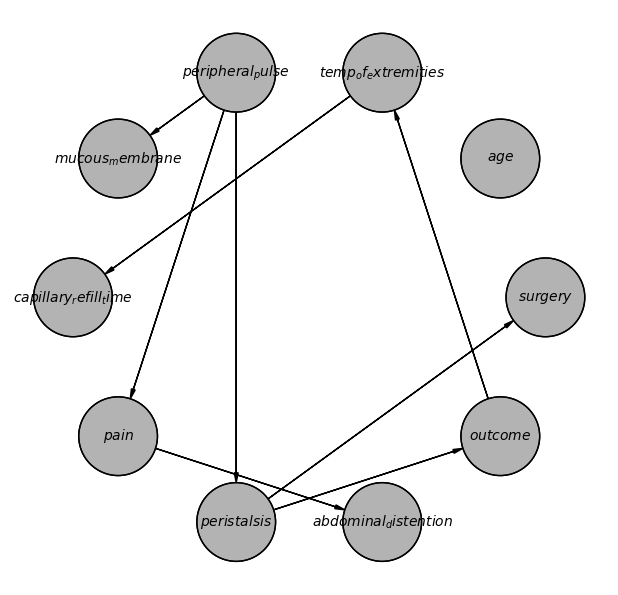

In [63]:
pgm = model.to_daft(pgm_params={'dpi':100, 'grid_unit':6, 'node_unit':2})
pgm.render()

In [64]:
bdeu = BDeuScore(data, equivalent_sample_size=10)
bic = BicScore(data)
print("BIC score: ",bic.score(model))
print("BDeu score: ", bdeu.score(model))

BIC score:  -1925.7103165521103
BDeu score:  -1812.5764439820766


# Best Model Inference:

By comparing the scores of the models we built, the best model is obtained through the PC algorithm with the lowest BIC and BDeu scores.

In [65]:
from pgmpy.estimators import PC
est = PC(data)
best_model = est.estimate(variant='orig', return_type='dag', significance_level=0.05, show_progress=False)

In [66]:
best_model = BayesianNetwork(best_model)

In [67]:
from pgmpy.estimators import BayesianEstimator
best_model.fit(data, estimator=BayesianEstimator, prior_type = "BDeu", equivalent_sample_size = 10, complete_samples_only=False)

In [68]:
infer = VariableElimination(best_model)

In [70]:
print(infer.query(['outcome'], show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.2705 |
+---------------------+----------------+
| outcome(euthanized) |         0.1287 |
+---------------------+----------------+
| outcome(lived)      |         0.6008 |
+---------------------+----------------+


In [71]:
best_model.active_trail_nodes(['outcome'])

{'outcome': {'abdominal_distention',
  'outcome',
  'peripheral_pulse',
  'temp_of_extremities'}}

As 'pain' is not in the list of active trail nodes, thus including it would not change the posterior probability of outcome.

In [72]:
print(infer.query(['outcome'], evidence={'pain':'extreme_pain'}, show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.2705 |
+---------------------+----------------+
| outcome(euthanized) |         0.1287 |
+---------------------+----------------+
| outcome(lived)      |         0.6008 |
+---------------------+----------------+


In [ ]:
print(infer.query(['outcome'], evidence={'peripheral_pulse': 'absent', 'abdominal_distention': 'severe'
                                         , 'temp_of_extremities': 'warm'}, show_progress=False))

By adding 'peripheral pulse = absent' in the evidence, the probability of dying or euthanizing the horse increases.

In [73]:
print(infer.query(['outcome'], evidence={'peripheral_pulse': 'absent'}, show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.4035 |
+---------------------+----------------+
| outcome(euthanized) |         0.4035 |
+---------------------+----------------+
| outcome(lived)      |         0.1930 |
+---------------------+----------------+


By adding 'abdominal distention = severe' the probability of euthanizing increases. You can see that in this case the probability of the horse to survive is low (five percent). 

In [74]:
print(infer.query(['outcome'], evidence={'peripheral_pulse': 'absent', 'abdominal_distention': 'severe'}, show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.3333 |
+---------------------+----------------+
| outcome(euthanized) |         0.6092 |
+---------------------+----------------+
| outcome(lived)      |         0.0575 |
+---------------------+----------------+


In [75]:
data['temp_of_extremities'].unique()

array(['cool', nan, 'normal', 'cold', 'warm'], dtype=object)

In [76]:
print(infer.query(['outcome'], evidence={'peripheral_pulse': 'absent', 'abdominal_distention': 'severe'
                                         , 'temp_of_extremities': 'warm'}, show_progress=False))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.3333 |
+---------------------+----------------+
| outcome(euthanized) |         0.6092 |
+---------------------+----------------+
| outcome(lived)      |         0.0575 |
+---------------------+----------------+


The last two posterior probabilities are the same. The reason is that when including 'peripheral pulse' and 'abdominal distention' in the evidence, there would be no active trail between 'outcome' and 'temperature of exttremities'.

In [77]:
best_model.active_trail_nodes(['outcome'], observed=['peripheral_pulse', 'abdominal_distention'])

{'outcome': {'outcome'}}

As infering queries with variable elimination is fast in the proposed networks, there is no need for approximate sampling to speed up the inference. I just list in the bottom some ways of using approximation sampling to infer the interesting probabilistic features of the model.

# Approximate Sampling:

In [82]:
from pgmpy.sampling import BayesianModelSampling, GibbsSampling
from pgmpy.inference.ApproxInference import ApproxInference
from pgmpy.factors.discrete import State
sampler = BayesianModelSampling(best_model)
gsampler = GibbsSampling(best_model)
infer = ApproxInference(best_model)

In [83]:
print(infer.get_distribution(data, ['outcome']))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.2575 |
+---------------------+----------------+
| outcome(euthanized) |         0.1472 |
+---------------------+----------------+
| outcome(lived)      |         0.5953 |
+---------------------+----------------+


In [84]:
import time
start_time = time.time()
print(infer.query(variables=['outcome'], n_samples=10000,  evidence={'peripheral_pulse': 'absent', 
                                                                   'abdominal_distention': 'severe'}, show_progress=False))
print("--- %s seconds ---" % (time.time() - start_time))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.3306 |
+---------------------+----------------+
| outcome(euthanized) |         0.6119 |
+---------------------+----------------+
| outcome(lived)      |         0.0575 |
+---------------------+----------------+
--- 3.1670799255371094 seconds ---


In [85]:
start_time = time.time()
print(infer.get_distribution(sampler.likelihood_weighted_sample(evidence=[State('peripheral_pulse', 'absent'), 
                                                                          State('abdominal_distention', 'severe')]
                                                                , size = 10000, show_progress=False), ['outcome']))
print("--- %s seconds ---" % (time.time() - start_time))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.3349 |
+---------------------+----------------+
| outcome(euthanized) |         0.6088 |
+---------------------+----------------+
| outcome(lived)      |         0.0563 |
+---------------------+----------------+
--- 0.0609438419342041 seconds ---


In [86]:
start_time = time.time()
print(infer.get_distribution(sampler.rejection_sample(evidence=[State('peripheral_pulse', 'absent'), 
                                                                          State('abdominal_distention', 'severe')]
                                                                , size = 10000, show_progress=False), ['outcome']))
print("--- %s seconds ---" % (time.time() - start_time))

+---------------------+----------------+
| outcome             |   phi(outcome) |
+=====================+================+
| outcome(died)       |         0.3284 |
+---------------------+----------------+
| outcome(euthanized) |         0.6141 |
+---------------------+----------------+
| outcome(lived)      |         0.0575 |
+---------------------+----------------+
--- 3.2871217727661133 seconds ---


In [89]:
start_time = time.time()
print(infer.get_distribution(gsampler.sample(size = 10000), ['outcome']))
print("--- %s seconds ---" % (time.time() - start_time))


+------------+----------------+
| outcome    |   phi(outcome) |
+============+================+
| outcome(0) |         0.2632 |
+------------+----------------+
| outcome(1) |         0.1212 |
+------------+----------------+
| outcome(2) |         0.6156 |
+------------+----------------+
--- 4.992697238922119 seconds ---


# Conclusion:

We see that in the best model, only three nodes are connected to the output variable. One can try to build the model through the PC algorithm with difference dependency significances and evaluate the results. 
These probabilistic models and inferences are useful for training the veterinarians and evaluating their skills. These models can act like a simulator of the process of examination and inspection of the patient and evaluating their condition. It should be kept in mind that these approaches are not meant to replace the human examination and evaluation and they only act as an assistant to the human expert. 